In [1]:
import pandas as pd

## Loading actives reports

In [2]:
active_reports = pd.read_csv("datasets/active_reports.csv", low_memory=False)

In [3]:
active_reports.shape

(7101, 50)

## Loading lightning performance

In [4]:
lightning_performance = pd.read_csv("data/Salesforce/Salesforce/ELF/LightningPerformance/2022-06-04_LightningPerformance.csv"
                                    ,low_memory=False)

In [5]:
list(lightning_performance.columns)

['EVENT_TYPE',
 'TIMESTAMP',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'CLIENT_ID',
 'SESSION_KEY',
 'LOGIN_KEY',
 'USER_TYPE',
 'APP_NAME',
 'DEVICE_PLATFORM',
 'SDK_APP_VERSION',
 'OS_NAME',
 'OS_VERSION',
 'USER_AGENT',
 'BROWSER_NAME',
 'BROWSER_VERSION',
 'SDK_VERSION',
 'DEVICE_MODEL',
 'DEVICE_ID',
 'SDK_APP_TYPE',
 'CLIENT_GEO',
 'CONNECTION_TYPE',
 'UI_EVENT_ID',
 'UI_EVENT_TYPE',
 'UI_EVENT_SOURCE',
 'UI_EVENT_TIMESTAMP',
 'PAGE_START_TIME',
 'DURATION',
 'DEVICE_SESSION_ID',
 'TIMESTAMP_DERIVED',
 'USER_ID_DERIVED',
 'CLIENT_IP']

## Merge active reports with lightning performance

In [6]:
common_columns = ['USER_ID_DERIVED', 'SESSION_KEY', 'LOGIN_KEY', 'ORGANIZATION_ID', 'CLIENT_IP']

In [7]:
lightning_performance.drop(['EVENT_TYPE','TIMESTAMP','REQUEST_ID','USER_ID','USER_TYPE','TIMESTAMP_DERIVED']
                           , inplace=True, axis=1)

In [8]:
ltng_full_reports_performance = pd.merge(left=active_reports, right=lightning_performance, on=common_columns)

In [9]:
ltng_full_reports_performance.shape

(723082, 72)

In [10]:
list(ltng_full_reports_performance.columns)

['CreatedById',
 'CreatedDate',
 'Description',
 'DeveloperName',
 'FolderName',
 'Format',
 'Id',
 'IsDeleted',
 'LastModifiedById',
 'LastModifiedDate',
 'LastReferencedDate',
 'LastRunDate',
 'LastViewedDate',
 'Name',
 'NamespacePrefix',
 'OwnerId',
 'ReportTypeApiName',
 'SystemModstamp',
 'EVENT_TYPE',
 'TIMESTAMP',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'RUN_TIME',
 'CPU_TIME',
 'URI',
 'SESSION_KEY',
 'LOGIN_KEY',
 'USER_TYPE',
 'REQUEST_STATUS',
 'DB_TOTAL_TIME',
 'ENTITY_NAME',
 'DISPLAY_TYPE',
 'RENDERING_TYPE',
 'REPORT_ID',
 'ROW_COUNT',
 'NUMBER_EXCEPTION_FILTERS',
 'NUMBER_COLUMNS',
 'AVERAGE_ROW_SIZE',
 'SORT',
 'DB_BLOCKS',
 'DB_CPU_TIME',
 'NUMBER_BUCKETS',
 'TIMESTAMP_DERIVED',
 'USER_ID_DERIVED',
 'CLIENT_IP',
 'URI_ID_DERIVED',
 'REPORT_ID_DERIVED',
 'ORIGIN',
 'IsActive',
 'CLIENT_ID',
 'APP_NAME',
 'DEVICE_PLATFORM',
 'SDK_APP_VERSION',
 'OS_NAME',
 'OS_VERSION',
 'USER_AGENT',
 'BROWSER_NAME',
 'BROWSER_VERSION',
 'SDK_VERSION',
 'DEVICE_MODEL',
 'DEVIC

In [11]:
ltng_full_reports_performance['CONNECTION_TYPE'].unique()

array([nan], dtype=object)

## Problematic reports

In [12]:
threshold = 120000

In [13]:
ltng_full_reports_performance  = ltng_full_reports_performance[ltng_full_reports_performance.DURATION >= threshold]

In [14]:
ltng_full_reports_performance.shape

(12234, 72)

### Analyzing ***CONNECTION_TYPE***

In [15]:
interest_columns = ['CONNECTION_TYPE', 'UI_EVENT_ID']

In [16]:
ltng_full_reports_performance_simplified = ltng_full_reports_performance[interest_columns]

In [17]:
ltng_full_reports_performance_simplified.shape

(12234, 2)

In [18]:
ltng_full_reports_performance_simplified['CONNECTION_TYPE'].unique()

array([nan], dtype=object)

Data don't have enough information/diversity to analyze after the merging between active reports and lightning performance

### Analyzing ***CONNECTION_TYPE*** for Lightning Performance logs

In [19]:
lightning_performance['CONNECTION_TYPE'].unique()

array([nan, 'wifi', 'WIFI', 'MOBILE;LTE', 'WiFi', 'none', '4g', '3g',
       'Mobile;CTRadioAccessTechnologyHSDPA'], dtype=object)

In [20]:
lightning_performance = lightning_performance[interest_columns]

In [21]:
lightning_performance.shape

(3115690, 2)

In [22]:
lightning_performance = lightning_performance.dropna(subset=['CONNECTION_TYPE'])

In [23]:
lightning_performance.shape

(1014, 2)

In [24]:
lightning_performance.head()

,CONNECTION_TYPE,UI_EVENT_ID
73694,wifi,ltng:newDefs
73695,wifi,ltng:performance
73696,wifi,ltng:performance
73697,wifi,ltng:performance
73702,wifi,ltng:performance


In [25]:
lightning_performance_group = lightning_performance.groupby(['CONNECTION_TYPE']).agg({'UI_EVENT_ID': 'count'})

In [26]:
lightning_performance_group.reset_index(inplace=True)

In [27]:
lightning_performance_group

,CONNECTION_TYPE,UI_EVENT_ID
0,3g,22
1,4g,7
2,MOBILE;LTE,63
3,Mobile;CTRadioAccessTechnologyHSDPA,48
4,WIFI,498
5,WiFi,11
6,none,18
7,wifi,347


In [29]:
WIFI_position = 0
for i in lightning_performance_group.index: 
     if lightning_performance_group['CONNECTION_TYPE'][i] == 'WIFI':
            WIFI_position = i
WIFI_position

4

In [31]:
index_list = []
for i in lightning_performance_group.index: 
     if lightning_performance_group['CONNECTION_TYPE'][i] == 'WiFi' or lightning_performance_group['CONNECTION_TYPE'][i] == 'wifi':
            lightning_performance_group['UI_EVENT_ID'][WIFI_position] += lightning_performance_group['UI_EVENT_ID'][i]
            index_list.append(i)
            
lightning_performance_group = lightning_performance_group.drop(index_list)
lightning_performance_group

C:\Users\klebe\AppData\Local\Temp\ipykernel_24608\3450789752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lightning_performance_group['UI_EVENT_ID'][WIFI_position] += lightning_performance_group['UI_EVENT_ID'][i]


,CONNECTION_TYPE,UI_EVENT_ID
0,3g,22
1,4g,7
2,MOBILE;LTE,63
3,Mobile;CTRadioAccessTechnologyHSDPA,48
4,WIFI,856
6,none,18


In [33]:
list_connection_type = lightning_performance_group['CONNECTION_TYPE'].tolist()
list_count = lightning_performance_group['UI_EVENT_ID'].tolist()

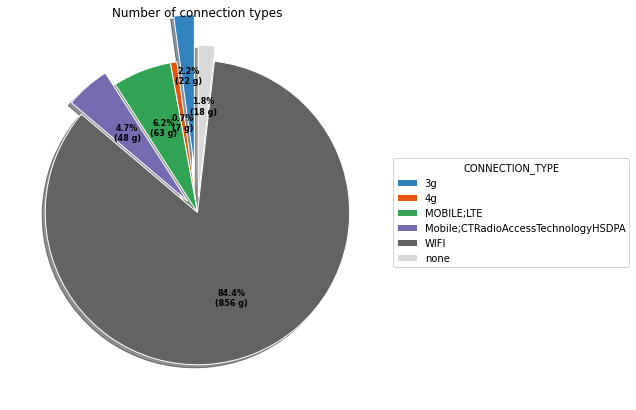

In [41]:
import numpy as np 
import matplotlib.pyplot as plt 
  
explode = (0.3, 0.0, 0.0, 0.1, 0.0, 0.1) 
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(6)*4)
wp = { 'linewidth' : 1, 'edgecolor' : "white" } 
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.1f}%\n({:d} g)".format(pct, absolute) 
fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(list_count,  
                                  autopct = lambda pct: func(pct, list_count), 
                                  explode = explode,  
                                  shadow = True, 
                                  colors = outer_colors, 
                                  startangle = 90, 
                                  wedgeprops = wp, 
                                  textprops = dict(color ="black")) 
ax.legend(wedges, list_connection_type, 
          title ="CONNECTION_TYPE", 
          loc ="center left", 
          bbox_to_anchor =(1, 0, 0.5, 1)) 
  
plt.setp(autotexts, size = 8, weight ="bold") 
ax.set_title("Number of connection types") 
plt.show()